Some useful website to explore CNNs Working => CNN Explainer, Explained Visually

# IMPORTS

In [2]:
import tensorflow as tf # Models
import numpy as np # Math Computations
import matplotlib.pyplot as plt # Plotting
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Normalization, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.regularizers import L2
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler
from google.colab import drive

# WANDB INSTALL AND LOGIN & INITIALIZATION, CONFIGURATION

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wandb login

wandb: Currently logged in as: ishu9t2. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

In [ ]:
wandb.init(
    project="Malaria-Detection",
    entity="ishu9t2"
)
wandb.finish()

In [ ]:
wandb.run

In [ ]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32,
}
CONFIGURATION = wandb.config

# DATASET PREPERATION

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteW7JIV2/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpesn85i5ltfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [6]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [7]:
ds = tf.data.Dataset.range(10)

In [8]:
len(ds)

10

In [9]:
print(list(ds.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
print(list(ds.take(4).as_numpy_iterator()))

[0, 1, 2, 3]


# DATA MODELLING

In [11]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [12]:
def split(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(train_ratio*dataset_size))
  val_test_dataset = dataset.skip(int(train_ratio*dataset_size))
  val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))
  test_dataset = val_test_dataset.skip(int(val_ratio*dataset_size))
  return train_dataset, val_dataset, test_dataset

In [13]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [14]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [15]:
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


# DATASET VISUALIZATION

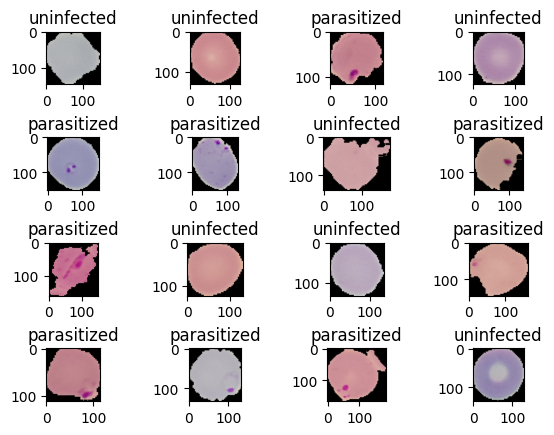

In [16]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.subplots_adjust(hspace=1, wspace=1)

# DATA PROCESSING

In [17]:
IM_SIZE = 224

In [18]:
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label # Dividing by 225 for normalization

In [19]:
train_dataset = train_dataset.map(resize_rescale)

In [20]:
for (image, label) in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [21]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
val_dataset = val_dataset.map(resize_rescale)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
test_dataset = test_dataset.map(resize_rescale)

# SEQUENTIAL API

## BUILDING MODEL

In [24]:
IM_SIZE = 224
DROPOUT_RATE = 0.0
REGULARIZATION_RATE = 0.0
N_FILTERS = 6
KERNEL_SIZE = 3
POOL_SIZE = 2
N_STRIDES = 1
LEARNING_RATE = 0.01
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE,strides=N_STRIDES,padding='valid',activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE,strides=N_STRIDES+2),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=N_FILTERS*2+4, kernel_size=KERNEL_SIZE,strides=N_STRIDES,padding='valid',activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE,strides=2),
    Dropout(rate=DROPOUT_RATE),

    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(10, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 16)       6

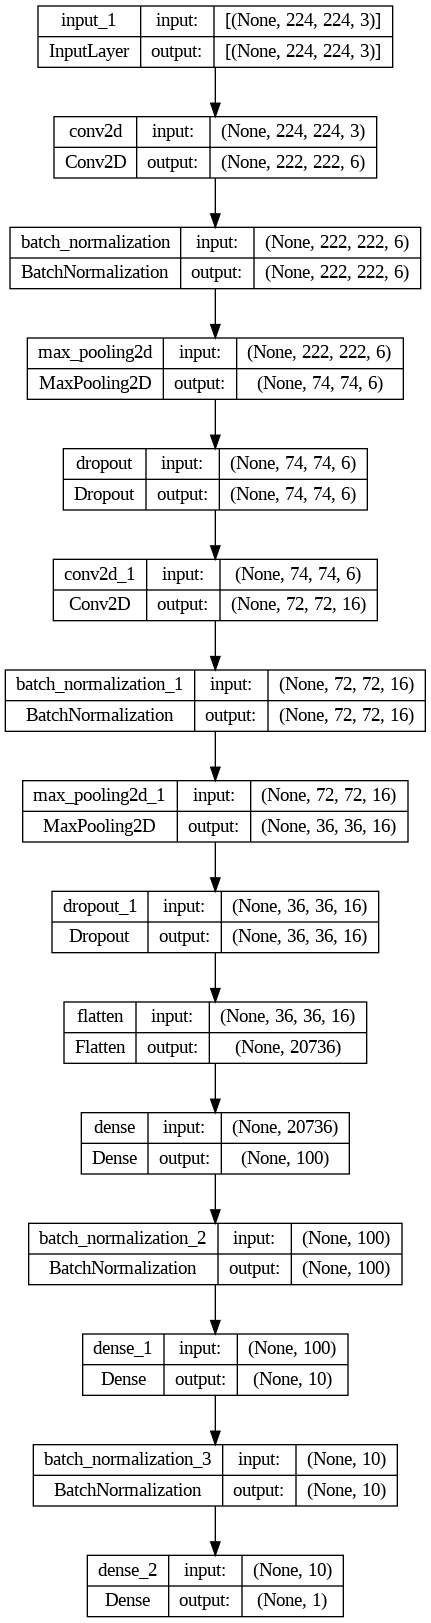

In [25]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

## CALLBACKS

### TENSORBOARD CALLBACK

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

### LEARNING RATE SCHEDULER

In [ ]:
METRIC_DIR = "./logs/metrics"
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr*tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  with train_writer.as_default():
    tf.summary.scalar("Learning Rate", data=learning_rate, step=epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

# HYPERPARAMETER TUNNING

In [ ]:
sweep_config = {
    "name": "Malaria-Detection-Sweep",
    "method": "random",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "LEARNING_RATE": {
            "distribution": "uniform",
            "min": 1e-4,
            "max": 1e-2,
        },
        "DROPOUT_RATE": {
            "min": 0.1,
            "max": 0.4,
        },
        "REGULARIZATION_RATE": {
            "distribution": "uniform",
            "min": 0.001,
            "max": 0.1
        },
        "N_DENSE_1": {
            "values": [16,32,64,128]
        },
        "N_DENSE_2": {
            "values": [16,32,64,128]
        },
    }
}
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: pugdz25l
Sweep URL: https://wandb.ai/ishu9t2/uncategorized/sweeps/pugdz25l


In [ ]:
def model_tune(config):
  model = tf.keras.Sequential([
      InputLayer(input_shape=(config.IM_SIZE, config.IM_SIZE, 3)),

      Conv2D(filters=config.N_FILTERS, kernel_size=config.KERNEL_SIZE,strides=config.N_STRIDES,padding='valid',activation='relu', kernel_regularizer=L2(config.REGULARIZATION_RATE)),
      BatchNormalization(),
      MaxPool2D(pool_size=config.POOL_SIZE,strides=config.N_STRIDES+2),
      Dropout(rate=config.DROPOUT_RATE),

      Conv2D(filters=config.N_FILTERS*2+4, kernel_size=config.KERNEL_SIZE,strides=config.N_STRIDES,padding='valid',activation='relu', kernel_regularizer=L2(config.REGULARIZATION_RATE)),
      BatchNormalization(),
      MaxPool2D(pool_size=config.POOL_SIZE,strides=2),
      Dropout(rate=config.DROPOUT_RATE),

      Flatten(),

      Dense(config.N_DENSE_1, activation="relu"),
      BatchNormalization(),

      Dense(config.N_DENSE_2, activation="relu"),
      BatchNormalization(),

      Dense(1, activation="sigmoid"),
  ])
  return model

In [ ]:
def train():
  with wandb.init(project="Malaria-Detection", entity="ishu9t2", config = CONFIGURATION) as run:
    config = wandb.config
    model = model_tune(config)
    model.compile(optimizer=Adam(learning_rate=config.LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])

count = 20
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: vyy8zkfz with config:
wandb: 	DROPOUT_RATE: 0.33504425095897605
wandb: 	LEARNING_RATE: 0.001828330247702825
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 32
wandb: 	REGULARIZATION_RATE: 0.035267008213046305
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
87/87 [==============================] - 36s 45ms/step - loss: 1.0932 - accuracy: 0.5619
Epoch 2/5
87/87 [==============================] - 15s 67ms/step - loss: 0.8912 - accuracy: 0.6305
Epoch 3/5
87/87 [==============================] - 15s 69ms/step - loss: 0.7649 - accuracy: 0.6813
Epoch 4/5
87/87 [==============================] - 15s 44ms/step - loss: 0.7115 - accuracy: 0.6886
Epoch 5/5
87/87 [==============================] - 15s 44ms/step - loss: 0.6808 - accuracy: 0.7093


accuracy,▁▄▇▇█
epoch,▁▃▅▆█
loss,█▅▂▂▁
accuracy,0.70926
epoch,4
loss,0.68083


wandb: Agent Starting Run: mshwriis with config:
wandb: 	DROPOUT_RATE: 0.2699456466898432
wandb: 	LEARNING_RATE: 0.009425992605938202
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.008813730940299563
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 45ms/step - loss: 0.8368 - accuracy: 0.5684
Epoch 2/5
87/87 [==============================] - 15s 45ms/step - loss: 0.7323 - accuracy: 0.5985
Epoch 3/5
87/87 [==============================] - 15s 45ms/step - loss: 0.6922 - accuracy: 0.6218
Epoch 4/5
87/87 [==============================] - 15s 45ms/step - loss: 0.8023 - accuracy: 0.5989
Epoch 5/5
87/87 [==============================] - 15s 48ms/step - loss: 0.7529 - accuracy: 0.6142


accuracy,▁▅█▅▇
epoch,▁▃▅▆█
loss,█▃▁▆▄
accuracy,0.61416
epoch,4
loss,0.75291


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hvm2ss0c with config:
wandb: 	DROPOUT_RATE: 0.11794320181928644
wandb: 	LEARNING_RATE: 0.008417843708361334
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.06228832856202115
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 45ms/step - loss: 0.9357 - accuracy: 0.6076
Epoch 2/5
87/87 [==============================] - 15s 50ms/step - loss: 0.7287 - accuracy: 0.6352
Epoch 3/5
87/87 [==============================] - 15s 54ms/step - loss: 0.7280 - accuracy: 0.6359
Epoch 4/5
87/87 [==============================] - 15s 60ms/step - loss: 0.6953 - accuracy: 0.6519
Epoch 5/5
87/87 [==============================] - 15s 46ms/step - loss: 0.7116 - accuracy: 0.6309


accuracy,▁▅▅█▅
epoch,▁▃▅▆█
loss,█▂▂▁▁
accuracy,0.63085
epoch,4
loss,0.7116


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nekd25yy with config:
wandb: 	DROPOUT_RATE: 0.2399340222487014
wandb: 	LEARNING_RATE: 0.0008214982800914219
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.016883976111275508
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
 6/87 [=>............................] - ETA: 4s - loss: 1.1337 - accuracy: 0.5000

87/87 [==============================] - 18s 44ms/step - loss: 0.9009 - accuracy: 0.6029
Epoch 2/5
87/87 [==============================] - 15s 48ms/step - loss: 0.7931 - accuracy: 0.6566
Epoch 3/5
87/87 [==============================] - 15s 51ms/step - loss: 0.7668 - accuracy: 0.6871
Epoch 4/5
87/87 [==============================] - 15s 46ms/step - loss: 0.7326 - accuracy: 0.6947
Epoch 5/5
87/87 [==============================] - 16s 55ms/step - loss: 0.6827 - accuracy: 0.7180


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▄▃▁
accuracy,0.71797
epoch,4
loss,0.68268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p42urkwb with config:
wandb: 	DROPOUT_RATE: 0.2760293944382882
wandb: 	LEARNING_RATE: 0.00653073139929219
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 128
wandb: 	REGULARIZATION_RATE: 0.06530993022674986
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 46ms/step - loss: 1.1835 - accuracy: 0.5858
Epoch 2/5
87/87 [==============================] - 15s 59ms/step - loss: 0.8179 - accuracy: 0.6345
Epoch 3/5
87/87 [==============================] - 14s 60ms/step - loss: 0.7361 - accuracy: 0.6294
Epoch 4/5
87/87 [==============================] - 14s 45ms/step - loss: 0.9222 - accuracy: 0.5114
Epoch 5/5
87/87 [==============================] - 14s 45ms/step - loss: 0.8625 - accuracy: 0.4933


accuracy,▆██▂▁
epoch,▁▃▅▆█
loss,█▂▁▄▃
accuracy,0.49328
epoch,4
loss,0.86251


wandb: Agent Starting Run: unuvpnhm with config:
wandb: 	DROPOUT_RATE: 0.17436850304892837
wandb: 	LEARNING_RATE: 0.006282925809039423
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.05279477452039978
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 60ms/step - loss: 0.9673 - accuracy: 0.6102
Epoch 2/5
87/87 [==============================] - 14s 54ms/step - loss: 0.8198 - accuracy: 0.6171
Epoch 3/5
87/87 [==============================] - 14s 45ms/step - loss: 0.7248 - accuracy: 0.6352
Epoch 4/5
87/87 [==============================] - 15s 60ms/step - loss: 0.7220 - accuracy: 0.6319
Epoch 5/5
87/87 [==============================] - 14s 60ms/step - loss: 0.7866 - accuracy: 0.6338


accuracy,▁▃█▇█
epoch,▁▃▅▆█
loss,█▄▁▁▃
accuracy,0.63376
epoch,4
loss,0.78657


wandb: Agent Starting Run: m00l5rn2 with config:
wandb: 	DROPOUT_RATE: 0.39464306786115955
wandb: 	LEARNING_RATE: 0.005942172030012106
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.014765290338725406
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 46ms/step - loss: 0.6612 - accuracy: 0.7423
Epoch 2/5
87/87 [==============================] - 14s 49ms/step - loss: 0.4413 - accuracy: 0.8588
Epoch 3/5
87/87 [==============================] - 14s 46ms/step - loss: 0.3341 - accuracy: 0.9034
Epoch 4/5
87/87 [==============================] - 15s 55ms/step - loss: 0.3457 - accuracy: 0.8893
Epoch 5/5
87/87 [==============================] - 14s 45ms/step - loss: 0.3388 - accuracy: 0.9009


accuracy,▁▆█▇█
epoch,▁▃▅▆█
loss,█▃▁▁▁
accuracy,0.90091
epoch,4
loss,0.33876


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2zeje011 with config:
wandb: 	DROPOUT_RATE: 0.23336021443373317
wandb: 	LEARNING_RATE: 0.0054893961949682235
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.027454919815394913
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 51ms/step - loss: 0.9325 - accuracy: 0.6211
Epoch 2/5
87/87 [==============================] - 14s 48ms/step - loss: 0.7384 - accuracy: 0.6512
Epoch 3/5
87/87 [==============================] - 14s 46ms/step - loss: 0.6905 - accuracy: 0.6526
Epoch 4/5
87/87 [==============================] - 15s 52ms/step - loss: 0.7314 - accuracy: 0.6534
Epoch 5/5
87/87 [==============================] - 15s 60ms/step - loss: 0.6975 - accuracy: 0.6697


accuracy,▁▅▆▆█
epoch,▁▃▅▆█
loss,█▂▁▂▁
accuracy,0.66969
epoch,4
loss,0.69748


wandb: Agent Starting Run: uakwwd2f with config:
wandb: 	DROPOUT_RATE: 0.10446785985916944
wandb: 	LEARNING_RATE: 0.0002662870179017279
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.00136136690914914
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 54ms/step - loss: 0.7177 - accuracy: 0.6127
Epoch 2/5
87/87 [==============================] - 15s 62ms/step - loss: 0.5632 - accuracy: 0.7169
Epoch 3/5
87/87 [==============================] - 14s 60ms/step - loss: 0.5013 - accuracy: 0.7633
Epoch 4/5
87/87 [==============================] - 14s 50ms/step - loss: 0.4723 - accuracy: 0.7851
Epoch 5/5
87/87 [==============================] - 14s 48ms/step - loss: 0.3717 - accuracy: 0.8465


accuracy,▁▄▆▆█
epoch,▁▃▅▆█
loss,█▅▄▃▁
accuracy,0.84646
epoch,4
loss,0.37167


wandb: Agent Starting Run: 6fvl9e6c with config:
wandb: 	DROPOUT_RATE: 0.2834197882516378
wandb: 	LEARNING_RATE: 0.007065125171180447
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 128
wandb: 	REGULARIZATION_RATE: 0.0112564725009472
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 48ms/step - loss: 0.8780 - accuracy: 0.6015
Epoch 2/5
87/87 [==============================] - 14s 47ms/step - loss: 0.7344 - accuracy: 0.6621
Epoch 3/5
87/87 [==============================] - 14s 46ms/step - loss: 0.6906 - accuracy: 0.6762
Epoch 4/5
87/87 [==============================] - 15s 48ms/step - loss: 0.5925 - accuracy: 0.7492
Epoch 5/5
87/87 [==============================] - 15s 59ms/step - loss: 0.4188 - accuracy: 0.8563


accuracy,▁▃▃▅█
epoch,▁▃▅▆█
loss,█▆▅▄▁
accuracy,0.85626
epoch,4
loss,0.41885


wandb: Agent Starting Run: o059916f with config:
wandb: 	DROPOUT_RATE: 0.12633808235086488
wandb: 	LEARNING_RATE: 0.008947336822052813
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.016983637197171577
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 47ms/step - loss: 0.8339 - accuracy: 0.5942
Epoch 2/5
87/87 [==============================] - 15s 56ms/step - loss: 0.6840 - accuracy: 0.6534
Epoch 3/5
87/87 [==============================] - 15s 62ms/step - loss: 0.6530 - accuracy: 0.6526
Epoch 4/5
87/87 [==============================] - 14s 46ms/step - loss: 0.6470 - accuracy: 0.6642
Epoch 5/5
87/87 [==============================] - 14s 46ms/step - loss: 0.6840 - accuracy: 0.6595


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▂
accuracy,0.65953
epoch,4
loss,0.68401


wandb: Agent Starting Run: v4o6aowy with config:
wandb: 	DROPOUT_RATE: 0.21433685401716004
wandb: 	LEARNING_RATE: 0.009323619928932478
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 16
wandb: 	REGULARIZATION_RATE: 0.02700142126973305
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 47ms/step - loss: 0.9185 - accuracy: 0.6062
Epoch 2/5
87/87 [==============================] - 14s 47ms/step - loss: 0.7520 - accuracy: 0.6352
Epoch 3/5
87/87 [==============================] - 16s 60ms/step - loss: 0.8710 - accuracy: 0.6479
Epoch 4/5
87/87 [==============================] - 15s 51ms/step - loss: 0.6920 - accuracy: 0.6653
Epoch 5/5
87/87 [==============================] - 15s 49ms/step - loss: 0.7249 - accuracy: 0.6272


accuracy,▁▄▆█▃
epoch,▁▃▅▆█
loss,█▃▇▁▂
accuracy,0.62722
epoch,4
loss,0.72494


wandb: Agent Starting Run: kqga3b0l with config:
wandb: 	DROPOUT_RATE: 0.2621740312920583
wandb: 	LEARNING_RATE: 0.0026357809406300386
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 32
wandb: 	REGULARIZATION_RATE: 0.09219312438832802
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 49ms/step - loss: 1.2087 - accuracy: 0.6178
Epoch 2/5
87/87 [==============================] - 15s 62ms/step - loss: 0.9173 - accuracy: 0.6181
Epoch 3/5
87/87 [==============================] - 14s 62ms/step - loss: 0.8015 - accuracy: 0.6446
Epoch 4/5
87/87 [==============================] - 15s 54ms/step - loss: 0.7382 - accuracy: 0.6711
Epoch 5/5
87/87 [==============================] - 14s 47ms/step - loss: 0.7168 - accuracy: 0.6701


accuracy,▁▁▅██
epoch,▁▃▅▆█
loss,█▄▂▁▁
accuracy,0.67005
epoch,4
loss,0.71684


wandb: Agent Starting Run: eziw0cix with config:
wandb: 	DROPOUT_RATE: 0.32667608317672336
wandb: 	LEARNING_RATE: 0.008336512297612097
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.05072660664143144
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 62ms/step - loss: 0.9126 - accuracy: 0.6207
Epoch 2/5
87/87 [==============================] - 15s 63ms/step - loss: 0.6830 - accuracy: 0.6439
Epoch 3/5
87/87 [==============================] - 15s 48ms/step - loss: 0.6908 - accuracy: 0.6454
Epoch 4/5
87/87 [==============================] - 15s 61ms/step - loss: 0.6998 - accuracy: 0.6606
Epoch 5/5
87/87 [==============================] - 15s 49ms/step - loss: 0.6736 - accuracy: 0.6461


accuracy,▁▅▅█▅
epoch,▁▃▅▆█
loss,█▁▂▂▁
accuracy,0.6461
epoch,4
loss,0.67358


wandb: Agent Starting Run: u5wauqyf with config:
wandb: 	DROPOUT_RATE: 0.21562890606896337
wandb: 	LEARNING_RATE: 0.004246887008397999
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.08876346605703146
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 48ms/step - loss: 1.1709 - accuracy: 0.6098
Epoch 2/5
87/87 [==============================] - 15s 57ms/step - loss: 0.7352 - accuracy: 0.7053
Epoch 3/5
87/87 [==============================] - 15s 62ms/step - loss: 0.5317 - accuracy: 0.8283
Epoch 4/5
87/87 [==============================] - 14s 62ms/step - loss: 0.4020 - accuracy: 0.8929
Epoch 5/5
87/87 [==============================] - 14s 48ms/step - loss: 0.3443 - accuracy: 0.9005


accuracy,▁▃▆██
epoch,▁▃▅▆█
loss,█▄▃▁▁
accuracy,0.90054
epoch,4
loss,0.34427


wandb: Agent Starting Run: qvdc7rqn with config:
wandb: 	DROPOUT_RATE: 0.14522863139529069
wandb: 	LEARNING_RATE: 0.004704393485199001
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.038425505248287826
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 62ms/step - loss: 1.0218 - accuracy: 0.6113
Epoch 2/5
87/87 [==============================] - 15s 48ms/step - loss: 0.7136 - accuracy: 0.6624
Epoch 3/5
87/87 [==============================] - 15s 62ms/step - loss: 0.7275 - accuracy: 0.6672
Epoch 4/5
87/87 [==============================] - 15s 62ms/step - loss: 0.6226 - accuracy: 0.7394
Epoch 5/5
87/87 [==============================] - 15s 56ms/step - loss: 0.4637 - accuracy: 0.8461


accuracy,▁▃▃▅█
epoch,▁▃▅▆█
loss,█▄▄▃▁
accuracy,0.8461
epoch,4
loss,0.46374


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t2lm3vbu with config:
wandb: 	DROPOUT_RATE: 0.3898303666087276
wandb: 	LEARNING_RATE: 0.009467745192056258
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 128
wandb: 	REGULARIZATION_RATE: 0.039800801685434435
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 48ms/step - loss: 1.0462 - accuracy: 0.6123
Epoch 2/5
87/87 [==============================] - 15s 55ms/step - loss: 0.8241 - accuracy: 0.6319
Epoch 3/5
87/87 [==============================] - 15s 52ms/step - loss: 0.6816 - accuracy: 0.6526
Epoch 4/5
87/87 [==============================] - 15s 48ms/step - loss: 0.6689 - accuracy: 0.6559
Epoch 5/5
87/87 [==============================] - 14s 48ms/step - loss: 0.7399 - accuracy: 0.6363


accuracy,▁▄▇█▅
epoch,▁▃▅▆█
loss,█▄▁▁▂
accuracy,0.6363
epoch,4
loss,0.7399


wandb: Agent Starting Run: jsk3flsu with config:
wandb: 	DROPOUT_RATE: 0.3647872742141379
wandb: 	LEARNING_RATE: 0.0007332608380948979
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.08350705468105547
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 19s 57ms/step - loss: 1.5874 - accuracy: 0.6196
Epoch 2/5
87/87 [==============================] - 14s 47ms/step - loss: 1.2707 - accuracy: 0.6788
Epoch 3/5
87/87 [==============================] - 15s 49ms/step - loss: 1.0474 - accuracy: 0.7147
Epoch 4/5
87/87 [==============================] - 14s 47ms/step - loss: 0.9405 - accuracy: 0.7205
Epoch 5/5
87/87 [==============================] - 15s 52ms/step - loss: 0.7488 - accuracy: 0.8022


accuracy,▁▃▅▅█
epoch,▁▃▅▆█
loss,█▅▃▃▁
accuracy,0.80218
epoch,4
loss,0.74885


wandb: Agent Starting Run: uagpf0a8 with config:
wandb: 	DROPOUT_RATE: 0.21060398438893368
wandb: 	LEARNING_RATE: 0.001191549763696354
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.025257800087945512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 49ms/step - loss: 0.9259 - accuracy: 0.6207
Epoch 2/5
87/87 [==============================] - 15s 51ms/step - loss: 0.7740 - accuracy: 0.6719
Epoch 3/5
87/87 [==============================] - 15s 48ms/step - loss: 0.6828 - accuracy: 0.7132
Epoch 4/5
87/87 [==============================] - 14s 48ms/step - loss: 0.5260 - accuracy: 0.8065
Epoch 5/5
87/87 [==============================] - 14s 47ms/step - loss: 0.3454 - accuracy: 0.8962


accuracy,▁▂▃▆█
epoch,▁▃▅▆█
loss,█▆▅▃▁
accuracy,0.89619
epoch,4
loss,0.34537


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 95gn9zav with config:
wandb: 	DROPOUT_RATE: 0.18414988317429765
wandb: 	LEARNING_RATE: 0.009632931963664496
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 128
wandb: 	REGULARIZATION_RATE: 0.07806057821863362
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
87/87 [==============================] - 18s 50ms/step - loss: 1.1520 - accuracy: 0.6152
Epoch 2/5
87/87 [==============================] - 15s 53ms/step - loss: 0.8045 - accuracy: 0.6225
Epoch 3/5
87/87 [==============================] - 14s 48ms/step - loss: 0.7806 - accuracy: 0.6316
Epoch 4/5
87/87 [==============================] - 14s 61ms/step - loss: 0.7925 - accuracy: 0.6523
Epoch 5/5
87/87 [==============================] - 15s 49ms/step - loss: 0.7790 - accuracy: 0.6211


accuracy,▁▂▄█▂
epoch,▁▃▅▆█
loss,█▁▁▁▁
accuracy,0.62105
epoch,4
loss,0.77901


In [ ]:
wandb.finish()

# MODEL TRAINING

In [26]:
METRICS = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),BinaryAccuracy('accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [27]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=METRICS)

In [28]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20,
                    verbose=1,)
                    #callbacks=[WandbCallback(validation_data=val_dataset,labels=LABELS,data_type='image')])

Epoch 1/20
689/689 [==============================] - 64s 72ms/step - loss: 0.4112 - tp: 8993.0000 - fp: 2242.0000 - tn: 8781.0000 - fn: 2030.0000 - accuracy: 0.8062 - precision: 0.8004 - recall: 0.8158 - auc: 0.8927 - val_loss: 0.2528 - val_tp: 1368.0000 - val_fp: 216.0000 - val_tn: 1146.0000 - val_fn: 25.0000 - val_accuracy: 0.9125 - val_precision: 0.8636 - val_recall: 0.9821 - val_auc: 0.9768
Epoch 2/20
689/689 [==============================] - 47s 69ms/step - loss: 0.1831 - tp: 10524.0000 - fp: 804.0000 - tn: 10217.0000 - fn: 501.0000 - accuracy: 0.9408 - precision: 0.9290 - recall: 0.9546 - auc: 0.9749 - val_loss: 0.2420 - val_tp: 1349.0000 - val_fp: 130.0000 - val_tn: 1233.0000 - val_fn: 43.0000 - val_accuracy: 0.9372 - val_precision: 0.9121 - val_recall: 0.9691 - val_auc: 0.9741
Epoch 3/20
689/689 [==============================] - 53s 77ms/step - loss: 0.1702 - tp: 10557.0000 - fp: 756.0000 - tn: 10267.0000 - fn: 466.0000 - accuracy: 0.9446 - precision: 0.9332 - recall: 0.9577

# CUSTOM

CUSTOM LOSS METHOD (WITH PARAMETERS)

In [ ]:
@tf.function
def custom_bce(y_true, y_pred):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)
  return loss(y_true, y_pred)

CUSTOM MODEL

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.1)
EPOCHS = 1
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()

In [ ]:
@tf.function
def training_model(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = model(x_batch, training=True)
      loss = custom_bce(y_batch, y_pred)
  partial_derivatives = recorder.gradient(loss, model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

In [ ]:
@tf.function
def validation(x_batch_val, y_batch_val):
  y_batch_val_pred = model(x_batch_val, training=False)
  val_loss = custom_bce(y_batch_val, y_batch_val_pred)
  METRIC_VAL.update_state(y_batch_val, y_batch_val_pred)
  return val_loss

In [ ]:
# @tf.function
def model_fitting():
  for epoch in range(EPOCHS):

    for (x_batch, y_batch) in train_dataset:
      loss = training_model(x_batch, y_batch)
    print(loss)
    print(METRIC.result())
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      val_loss = validation(x_batch_val, y_batch_val)
    print(val_loss)
    print(METRIC_VAL.result())
    METRIC_VAL.reset_states()

In [ ]:
model_fitting()

#VISUALIZATIONS

## TENSORBOARD

In [ ]:
%load_ext tensorboard

In [ ]:
LOG_DIR = "./logs"

In [ ]:
tensorboard --logdir="./logs"

## LOSS

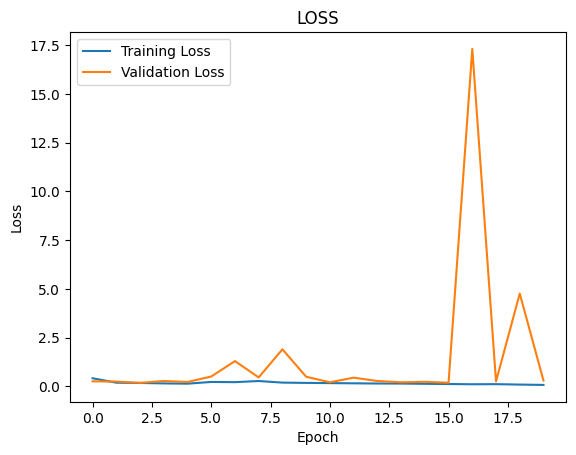

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## ACCURACY / PERFORMANCE

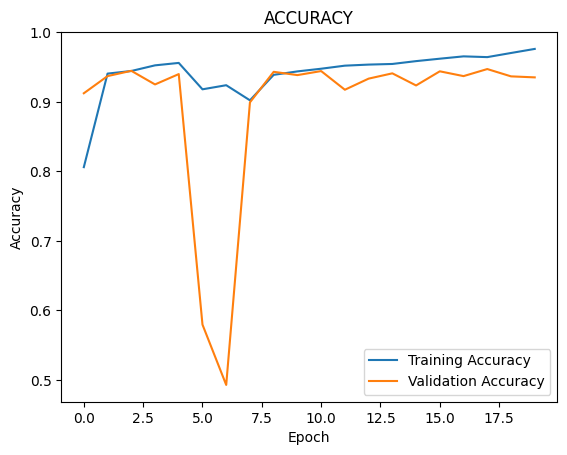

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ACCURACY')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [32]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [33]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [34]:
test_dataset = test_dataset.batch(1)

In [35]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

## VISUALIZING CONFUSION MATRIX

In [36]:
labels = []
predicted = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y[0])
  predicted.append(model.predict(x)[0][0])

1/1 [==============================] - 0s 20ms/step


In [37]:
print(labels)

[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 

In [38]:
print(predicted)

[0.9698817, 0.012274605, 0.005197607, 0.9994803, 0.0019618566, 0.663291, 0.024215717, 0.99958855, 2.5317675e-05, 0.86200035, 0.00022078754, 0.9999658, 0.99986374, 0.00019800213, 0.99868304, 0.9998722, 0.9995542, 0.99882406, 0.9994567, 0.99878675, 0.3039567, 0.9994289, 0.00065138465, 0.00016721386, 0.9904156, 0.012052683, 0.9999659, 0.9991196, 9.454949e-05, 0.9994677, 0.002153292, 4.659093e-05, 0.998782, 0.7157772, 1.0439424e-09, 2.4538682e-05, 0.00018137519, 0.00014910838, 0.030590342, 6.411972e-05, 0.9999337, 0.047196407, 0.0055418937, 0.9998995, 2.1887518e-06, 0.9956833, 0.9999492, 0.5930177, 0.00014145073, 0.00059707183, 0.00033253134, 0.9993117, 0.99996495, 0.9999498, 0.99747664, 0.99913174, 0.9977429, 0.99914336, 3.428915e-05, 0.88119185, 0.9994691, 0.00012063319, 0.9971359, 1.2030188e-06, 0.00045593132, 0.9996464, 9.2804004e-07, 0.00018848143, 0.0018861719, 0.9988564, 0.9990308, 0.95963085, 0.028019626, 0.9988399, 0.9995097, 0.9999778, 0.021689707, 0.0002719606, 0.99966156, 0.994

In [39]:
len(predicted)

2757

In [40]:
len(labels)

2757

In [41]:
threshold = 0.95
predicted_value = []
for x in predicted:
  if x>threshold:
    predicted_value.append(1)
  else:
    predicted_value.append(0)
cm = confusion_matrix(labels, predicted_value)
print(cm)

[[1294   98]
 [  84 1281]]


In [42]:
# tp: 1347.0000 - fp: 262.0000 - tn: 1128.0000 - fn: 20.0000

Text(0.5, 58.7222222222222, 'Predicted')

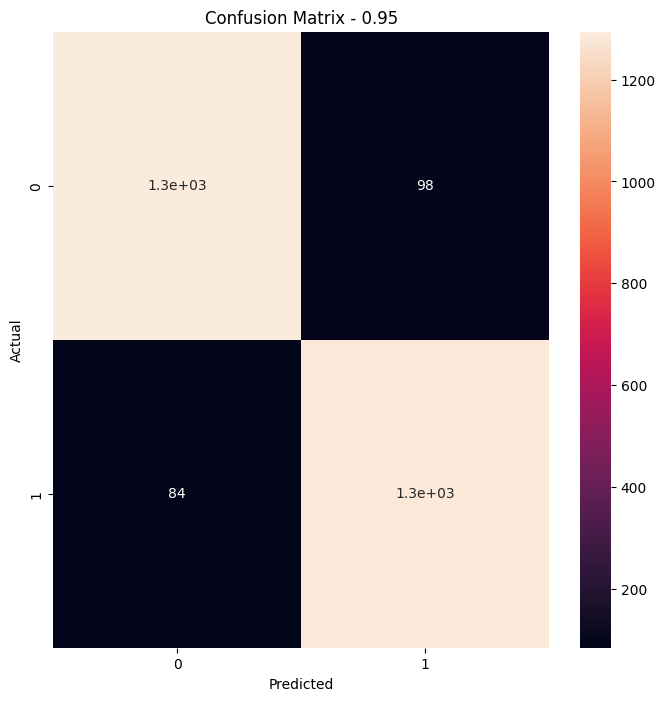

In [43]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title(f'Confusion Matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## ROC CURVE

In [44]:
fp, tp, thresholds = roc_curve(labels, predicted)

In [45]:
print(len(fp), len(tp), len(thresholds))

378 378 378


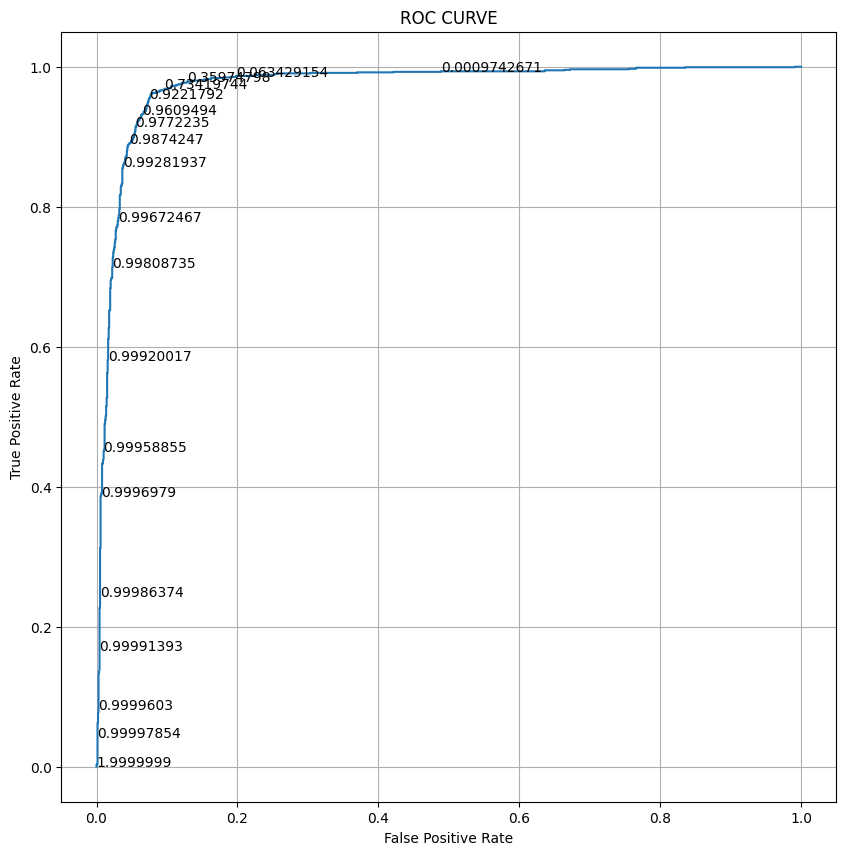

In [46]:
plt.figure(figsize=(10,10))
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
skip = 20
for i in range(0, len(fp), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.grid()
plt.show()

## PREDICTIONS

In [47]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [48]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 20ms/step


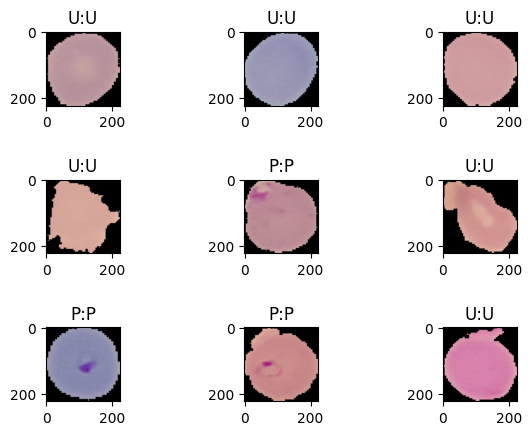

In [49]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.subplots_adjust(hspace=1, wspace=1)

# LOADING & SAVING

ON GOOGLE COLLAB

In [ ]:
# Configuration + Weights

In [ ]:
model.save("LenetSavedModel")

In [ ]:
load_model = tf.keras.models.load_model("LenetSavedModel")

In [ ]:
load_model.evaluate(test_dataset)

In [ ]:
# hdf5 version is light weight version of this save model

In [ ]:
model.save("LenetModel.hdf5")

In [ ]:
hdf5_model = tf.keras.models.load_model("LenetModel.hdf5")

In [ ]:
hdf5_model.evaluate(test_dataset)

In [ ]:
# Note in case of hdf5 custom layers configuration are not stored

In [ ]:
# Save Only Weights

In [ ]:
model.save_weights("weights/lenet_weights")

In [ ]:
# weight_model = model.load_weights("weights/lenet_weights")

ON DRIVE

In [ ]:
drive.mount('/content/drive')

In [ ]:
cp -r /content/LenetSavedModel/ /content/drive/MyDrive/MyLenetModel/

In [ ]:
# cp -r /content/drive/MyDrive/MyLenetModel/ /content/LenetSavedModel